In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

from preprocess import get_concat_results, mean_aggregate_results, MODEL_ORDER, FRAMEWORK_ORDER, make_key

%load_ext autoreload
%autoreload 2

pd.options.display.float_format = '{:.4f}'.format

In [3]:
def latexify_columns(row: tuple) -> str:
	idx = row[0]
	fields = [f"{float(f):.3f}" for f in row[1:]]
	return f"{idx}\t{' & '.join(fields)} \\\\"

def latexify_df(df: pd.DataFrame) -> None:
	for row in df.itertuples():
		print(latexify_columns(row))

COLUMNS = ["t_mean", "t_std", "l_median", "l_std"]

In [4]:
def join_tels(t, e, l) -> pd.DataFrame:
	def col_map(d: str) -> dict[str, str]:
		return {
			"elapsed_time_mean": f"{d}_mean", 
			"elapsed_time_median": f"{d}_median", 
			"elapsed_time_std": f"{d}_std",
			"phase": f"{d}_phase"
		}
	
	return pd.concat(
		([] if t is None else [t.rename(columns=col_map("t"))]) +
		([] if e is None else [e.rename(columns=col_map("e"))]) +
		([] if l is None else [l.rename(columns=col_map("l"))]),
		axis="columns"
	)

In [5]:
tdf, edf, ldf = get_concat_results("../results_ultimate_%d", 1, 16, train_preserve_warmup=False, full=True)

mtdf, medf, mldf = mean_aggregate_results(tdf, edf, ldf, train_preserve_epoch=False, latency_preserve_epoch=False)

# Analiza
cos tam ze modele do roznych zastosowan wiec analiza tez zostanie podzielona na sekcje. torch.compile mial wszystkie modele i byl na osobnym srodowisku, dlatego zostanie rozpatrzony w osobnej sekcji

## Klasyfikacja obrazów 
modele do klasyfikacji zostaly zaimplementowane w najwiekszej liczbie technologii i po kolei bedziemy przechodzic przez kolejne porownania miedzy nimi.

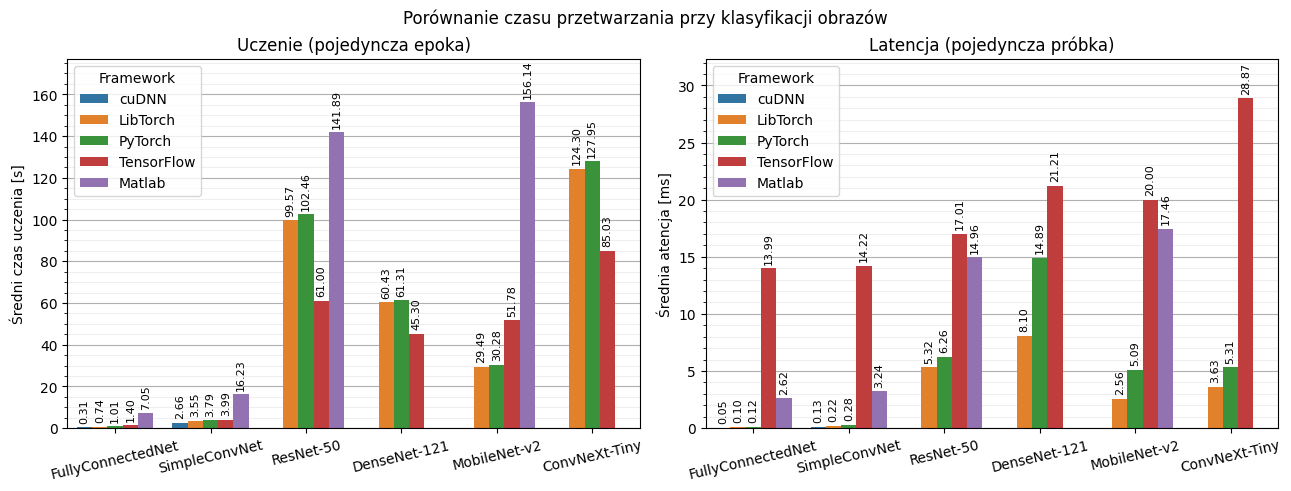

In [6]:
def clf_comp_plot(data: pd.DataFrame, order: list[str], ax, ylabel: str, title: str):
	sns.barplot(data=data, x="model_name", y="elapsed_time_" + ("median" if "atencja" in title else "mean"), 
			    hue="framework", order=order, zorder=2, ax=ax)
	ax.legend(title="Framework")
	ax.set_xlabel("")
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(ax.get_xticks())
	ax.set_xticklabels(ax.get_xticklabels(), rotation=13)
	ax.grid(axis="y", which="major", zorder=1)
	ax.minorticks_on()
	ax.tick_params(axis='x', which='minor', bottom=False)
	ax.grid(visible=True, axis="y", which="minor", alpha=0.2, zorder=1)
	_, top = ax.get_ylim()
	ax.set_ylim(top=top + (2 if "atencja" in title else 13))
	for container in ax.containers:
		ax.bar_label(container, fmt="{:.2f}", fontsize=8, padding=3, rotation="vertical")


fig, axes = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(12.8, 4.8)
fig.suptitle("Porównanie czasu przetwarzania przy klasyfikacji obrazów")

mtdf_clf = mtdf[(mtdf.model_name != "DCGAN") & (~mtdf.framework.isin(["PyTorch_eager", "PyTorch_compile"]))].copy()
clf_comp_plot(mtdf_clf, order=MODEL_ORDER[:-2], ax=axes[0], ylabel="Średni czas uczenia [s]", title="Uczenie (pojedyncza epoka)")

mldf_clf = mldf[(mldf.model_name != "DCGAN") & (mldf.phase == "latency") & (~mldf.framework.isin(["PyTorch_eager", "PyTorch_compile"]))].copy()
clf_comp_plot(mldf_clf, order=MODEL_ORDER[:-2], ax=axes[1], ylabel="Średnia atencja [ms]", title="Latencja (pojedyncza próbka)")

fig.savefig("../paper/plots/5.1-1.png")

widac ze dla uczeniea jest wiekszy rozstrzal i ciezko wyznaczyc jeden spojny trend miedzy roznymi technologiami. dla latencji sytuacja wyglada lepiej, Torch w wiekszosci przypadkow utrzymuje prowadzenie. 

wyglada na to ze TF domyslnie zgrywa wszystkie dane na CPU i nie za bardzo jest co z tym zrobic, stad ta stala czasowa

w pozostalej czesci tej sekcji zajemiemy sie
porownaniami poszczegolnych frameworkow, zaczynajac od prawdopodobnie najciekawszego z 
nich, tj. miedzy pytorchem a tensorflowem.
### PyTorch vs TensorFlow

In [7]:
py_t = mtdf[mtdf.framework.isin(["PyTorch", "TensorFlow"]) & ~mtdf.model_name.isin(["SODNet", "DCGAN", "NativeResNet-50"])].reset_index(drop=True).set_index(["model_name", "framework"])
py_e = medf[medf.framework.isin(["PyTorch", "TensorFlow"]) & ~medf.model_name.isin(["SODNet", "DCGAN", "NativeResNet-50"])].reset_index(drop=True).set_index(["model_name", "framework"])
py_l = mldf[mldf.framework.isin(["PyTorch", "TensorFlow"]) & ~mldf.model_name.isin(["SODNet", "DCGAN", "NativeResNet-50"])].reset_index(drop=True).set_index(["model_name", "framework"])

py_t = py_t.reindex(level=0, index=MODEL_ORDER[:-2])
py_e = py_e.reindex(level=0, index=MODEL_ORDER[:-2])
py_l = py_l.reindex(level=0, index=MODEL_ORDER[:-2])

py_df = join_tels(py_t, py_e, py_l)
py_df = py_df.drop([c for c in py_df.columns if "phase" in c], axis="columns")
display(py_df)
# tab5_1_2 = py_df[COLUMNS]
# latexify_df(tab5_1_2)

t_mean  t_median  t_std    e_mean  e_median  \
model_name        framework                                                  
FullyConnectedNet PyTorch      1.0090    1.0066 0.0067   92.0778   92.1485   
                  TensorFlow   1.4023    1.4045 0.0240  137.2953  136.6715   
SimpleConvNet     PyTorch      3.7868    3.7867 0.0100  224.6869  224.4340   
                  TensorFlow   3.9853    4.0075 0.1025  280.4895  286.7759   
ResNet-50         PyTorch    102.4621  102.2128 0.3672 4765.9581 4768.9851   
                  TensorFlow  61.0010   60.9613 0.1644 2656.1960 2650.7643   
DenseNet-121      PyTorch     61.3132   61.2491 0.1325 4306.9020 4303.8459   
                  TensorFlow  45.2986   45.3226 0.1976 2385.9528 2394.4783   
MobileNet-v2      PyTorch     30.2800   30.2807 0.0379 1755.5492 1745.7148   
                  TensorFlow  51.7830   51.8248 0.1141 1936.4504 1934.8201   
ConvNeXt-Tiny     PyTorch    127.9465  127.9039 0.1974 2978.0126 2976.4669   
                  TensorFlow  85.0272   85.0056 0.1079 5525.8958 5529.6553   

                               e_std  l_mean  l_median  l_std  
model_name        framework                                    
FullyConnectedNet PyTorch     1.1912  0.1255    0.1239 0.0056  
                  TensorFlow  4.9334 13.9940   13.9894 0.1524  
SimpleConvNet     PyTorch     1.2671  0.2823    0.2790 0.0139  
                  TensorFlow 17.9564 14.2474   14.2237 0.1691  
ResNet-50         PyTorch    16.6407  6.2661    6.2633 0.0743  
                  TensorFlow 20.7916 17.0580   17.0053 0.2598  
DenseNet-121      PyTorch     8.9271 14.9256   14.8936 0.4958  
                  TensorFlow 37.5081 21.2614   21.2083 0.2396  
MobileNet-v2      PyTorch    44.0594  5.1079    5.0929 0.1436  
                  TensorFlow 15.0244 18.7459   20.0022 1.6781  
ConvNeXt-Tiny     PyTorch     6.0759  5.3234    5.3105 0.1143  
                  TensorFlow 19.3404 28.8807   28.8668 1.3206

In [8]:
py_nostd = py_df.drop([c for c in py_df.columns if "std" in c or "phase" in c], axis="columns").reset_index(level=1)  # [["t_mean", "e_mean", "l_mean"]]

# display(py_nostd)
			
tf_nostd = py_nostd[py_nostd.framework == "TensorFlow"].drop("framework", axis=1)
pt_nostd = py_nostd[py_nostd.framework == "PyTorch"].drop("framework", axis=1)

pt_advantage = tf_nostd / pt_nostd * 100
tf_advantage = pt_nostd / tf_nostd * 100

display(pt_advantage)  # PT wykonuje sie `x/100 razy` lub `o (x-100)%` dluzej od TF
display(tf_advantage)  # TF wykonuje sie `x/100 razy` lub `o (x-100)%` dluzej od PT

# latexify_df(pt_advantage)
# print()
# latexify_df(tf_advantage)

,t_mean,t_median,e_mean,e_median,l_mean,l_median
model_name,,,,,,
FullyConnectedNet,138.9732,139.5264,149.1079,148.3167,11149.6595,11290.4860
SimpleConvNet,105.2406,105.8307,124.8357,127.7774,5046.8088,5097.3757
ResNet-50,59.5352,59.6415,55.7327,55.5834,272.2266,271.5075
DenseNet-121,73.8807,73.9971,55.3984,55.6358,142.4489,142.3989
MobileNet-v2,171.0137,171.1477,110.3045,110.8325,367.0023,392.7486
ConvNeXt-Tiny,66.4553,66.4605,185.5565,185.7792,542.5214,543.5832


,t_mean,t_median,e_mean,e_median,l_mean,l_median
model_name,,,,,,
FullyConnectedNet,71.9563,71.6710,67.0655,67.4233,0.8969,0.8857
SimpleConvNet,95.0204,94.4906,80.1053,78.2611,1.9815,1.9618
ResNet-50,167.9678,167.6684,179.4280,179.9098,36.7341,36.8314
DenseNet-121,135.3533,135.1404,180.5108,179.7404,70.2006,70.2253
MobileNet-v2,58.4749,58.4291,90.6581,90.2262,27.2478,25.4616
ConvNeXt-Tiny,150.4772,150.4653,53.8919,53.8273,18.4325,18.3964


**Wnioski:**
* przy treningu i usrednionej ewaluacji wielu obrazow (tu calego zbioru) walka jest wyrownana, zalezy od architektury i ciezko wyznaczyc jednoznacznie zwyciezce
* przy latencji natomiast pytorch bije tensorflowa na glowe, od 1.4 do nawet 11 razy szybciej! na modelach przecietnej wielkosci okolo 2-3 razy szybciej - mamy jasnego zwyciezce
* skad taka ogromna roznica dla tensorflowa miedzy ewaluacja a latencja? czyzby tensorflow dobrze sie skalowal ale nie radzil sobie z pojedynczymi probkami? sprawdzone w `batch-size-comp.ipynb` i to nieprawda

ponizej badanie wplywu rozmiaru batcha na czas przetwarzania roznych metod predykcji w TF

### PyTorch serio taki szybki?: sekcja o roznych metodach do predykcji pojedynczych sampli w TF oraz roznice miedzy nimi
wykres w `batch-size-comp.ipynb`

**Wnioski:**
* okazuje sie ze ilosc probek przy jednorazowej predykcji ma znaczenie, natomiast dla malych probek (czy mozna mowic o latencji na 64 probkach? no nie, raczej na max kilku) dalej jednoznacznie prowadzi pytorch
* TF oferuje pare metod: najszybsza okazuje sie `predict_on_batch` jednak ona przyjmuje tylko tensor i zwraca tensor skutkiem czego nie nalezy do pelnego API TF (`predict` przyjmuje tez callbacki, zbiera metryki i telemetrie, loguje - jest pelniejsza metoda wystawiana do klienta-uzytkownika frameworku), dlatego to `predict` byla uzywana w benchmarkach

### Wszystkie interpretowane
czyli PT, TF oraz Matlab

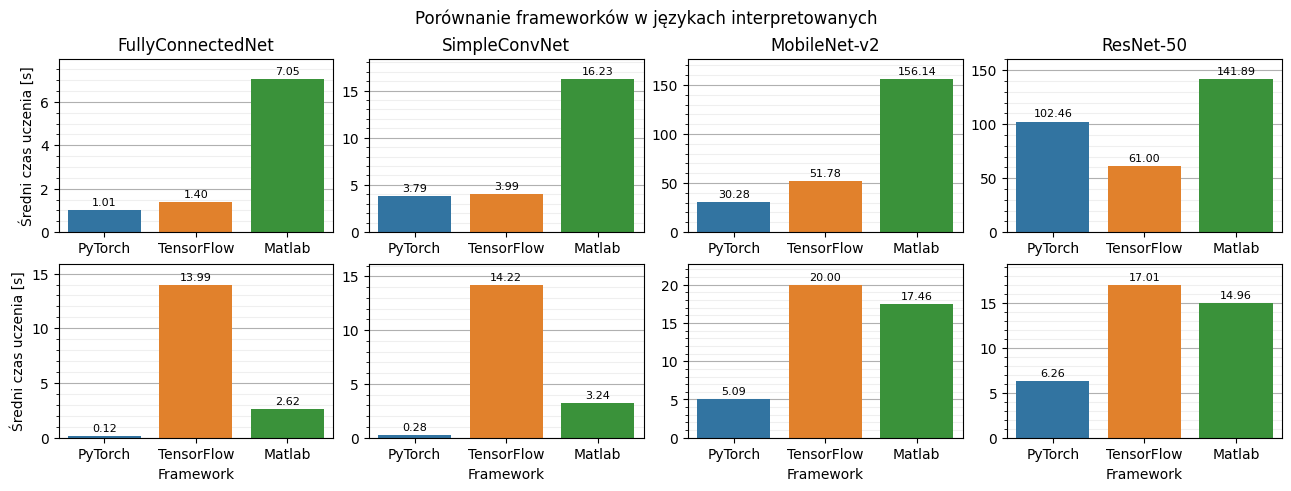

In [9]:
model_names = ['FullyConnectedNet', 'SimpleConvNet', 'MobileNet-v2', 'ResNet-50']
frameworks = ["PyTorch", "TensorFlow", "Matlab"]
t_data = mtdf[mtdf.framework.isin(frameworks) & mtdf.model_name.isin(model_names)]
l_data = mldf[mldf.framework.isin(frameworks) & mldf.model_name.isin(model_names)]

fig, axes = plt.subplots(2, 4, constrained_layout=True)
fig.set_size_inches(12.8, 4.8)
fig.suptitle("Porównanie frameworków w językach interpretowanych")

for i, (ax, model_name) in enumerate(zip(axes.flatten(), model_names * 2)):
	data = t_data if i < 4 else l_data
	data = data[data.model_name == model_name].reset_index(drop=True)
	data["hue"] = ["pt", "tf", "ml"]
	agg_func = "mean" if i < 4 else "median"
	sns.barplot(data=data, x="framework", y="elapsed_time_" + agg_func, 
			    order=frameworks, ax=ax, zorder=2, hue="hue")
	ax.get_legend().remove()
	ax.set_xlabel("Framework" if i >= 4 else "")
	ax.set_ylabel("Średni czas uczenia [s]" if i in [0, 4] else "")
	ax.set_title(model_name if i < 4 else "")
	ax.grid(axis="y", which="major", zorder=1)
	ax.minorticks_on()
	ax.tick_params(axis='x', which='minor', bottom=False)
	ax.grid(visible=True, axis="y", which="minor", alpha=0.2, zorder=1)
	_, top = ax.get_ylim()
	ax.set_ylim(top=top * 1.08)
	for container in ax.containers:
		ax.bar_label(container, fmt="{:.2f}", fontsize=8, padding=2)


fig.savefig("../paper/plots/5.1-4.png")

### Matlab: czas uczenia w funkcji epoki
cos tam ze matlab jako jedyny wykazywal taka ceche ze kazdy kolejny epoch byl dluzszy od poprzedniego, mialo to rowniez zwiazek z wielkoscia batcha

wykres w `batch-size-comp.ipynb`

### LibTorch vs PyTorch

In [10]:
torch_t = mtdf[mtdf.framework.isin(["PyTorch", "LibTorch"]) & ~mtdf.model_name.isin(["SODNet", "DCGAN", "NativeResNet-50"])].reset_index(drop=True).set_index(["model_name", "framework"])
torch_e = medf[medf.framework.isin(["PyTorch", "LibTorch"]) & ~medf.model_name.isin(["SODNet", "DCGAN", "NativeResNet-50"])].reset_index(drop=True).set_index(["model_name", "framework"])
torch_l = mldf[mldf.framework.isin(["PyTorch", "LibTorch"]) & ~mldf.model_name.isin(["SODNet", "DCGAN", "NativeResNet-50"])].reset_index(drop=True).set_index(["model_name", "framework"])

torch_t = torch_t.reindex(level=0, index=MODEL_ORDER[:-2])
torch_e = torch_e.reindex(level=0, index=MODEL_ORDER[:-2])
torch_l = torch_l.reindex(level=0, index=MODEL_ORDER[:-2])

torch_df = join_tels(torch_t, torch_e, torch_l)

torch_df

t_mean  t_median  t_std    e_phase    e_mean  \
model_name        framework                                                  
FullyConnectedNet LibTorch    0.7401    0.7401 0.0041  inference   62.5272   
                  PyTorch     1.0090    1.0066 0.0067  inference   92.0778   
SimpleConvNet     LibTorch    3.5509    3.5499 0.0089  inference  208.8479   
                  PyTorch     3.7868    3.7867 0.0100  inference  224.6869   
ResNet-50         LibTorch   99.5711   99.5709 0.3445  inference 4593.7244   
                  PyTorch   102.4621  102.2128 0.3672  inference 4765.9581   
DenseNet-121      LibTorch   60.4271   60.5012 0.1324  inference 4200.4231   
                  PyTorch    61.3132   61.2491 0.1325  inference 4306.9020   
MobileNet-v2      LibTorch   29.4948   29.4808 0.0452  inference 1579.4813   
                  PyTorch    30.2800   30.2807 0.0379  inference 1755.5492   
ConvNeXt-Tiny     LibTorch  124.2974  124.2690 0.2078  inference 2797.2381   
                  PyTorch   127.9465  127.9039 0.1974  inference 2978.0126   

                             e_median   e_std  l_phase  l_mean  l_median  \
model_name        framework                                                
FullyConnectedNet LibTorch    57.3952  7.9170  latency  0.1063    0.1034   
                  PyTorch     92.1485  1.1912  latency  0.1255    0.1239   
SimpleConvNet     LibTorch   208.8840  1.0965  latency  0.2212    0.2205   
                  PyTorch    224.4340  1.2671  latency  0.2823    0.2790   
ResNet-50         LibTorch  4593.4200 17.0964  latency  5.3338    5.3207   
                  PyTorch   4768.9851 16.6407  latency  6.2661    6.2633   
DenseNet-121      LibTorch  4185.6450 78.0223  latency  8.1376    8.1009   
                  PyTorch   4303.8459  8.9271  latency 14.9256   14.8936   
MobileNet-v2      LibTorch  1578.2600  9.2822  latency  2.5652    2.5600   
                  PyTorch   1745.7148 44.0594  latency  5.1079    5.0929   
ConvNeXt-Tiny     LibTorch  2796.3050  4.6056  latency  3.6398    3.6337   
                  PyTorch   2976.4669  6.0759  latency  5.3234    5.3105   

                             l_std  
model_name        framework         
FullyConnectedNet LibTorch  0.0184  
                  PyTorch   0.0056  
SimpleConvNet     LibTorch  0.0019  
                  PyTorch   0.0139  
ResNet-50         LibTorch  0.0448  
                  PyTorch   0.0743  
DenseNet-121      LibTorch  0.1356  
                  PyTorch   0.4958  
MobileNet-v2      LibTorch  0.0506  
                  PyTorch   0.1436  
ConvNeXt-Tiny     LibTorch  0.0494  
                  PyTorch   0.1143

In [11]:
torch_nostd = torch_df.drop([c for c in torch_df.columns if ("std" in c or "phase" in c)], axis="columns").reset_index(level=1)

libtorch_nostd = torch_nostd[torch_nostd.framework == "LibTorch"].drop("framework", axis=1)
pytorch_nostd = torch_nostd[torch_nostd.framework == "PyTorch"].drop("framework", axis=1)

lib_advantage = pytorch_nostd / libtorch_nostd * 100

display(lib_advantage)  # PT wykonuje sie `x/100 razy` lub `o (x-100)%` dluzej od LT

,t_mean,t_median,e_mean,e_median,l_mean,l_median
model_name,,,,,,
FullyConnectedNet,136.3425,136.0054,147.2604,160.5508,118.0386,119.8020
SimpleConvNet,106.6432,106.6702,107.5840,107.4443,127.6495,126.5775
ResNet-50,102.9035,102.6533,103.7493,103.8221,117.4792,117.7156
DenseNet-121,101.4663,101.2362,102.5350,102.8240,183.4155,183.8517
MobileNet-v2,102.6621,102.7136,111.1472,110.6101,199.1177,198.9388
ConvNeXt-Tiny,102.9357,102.9250,106.4626,106.4429,146.2576,146.1462


### LibTorch: native and imported models

In [12]:
def native_lt_filter(mdf: pd.DataFrame) -> pd.DataFrame:
	return (
		mdf[
			mdf.model_name.isin(["ResNet-50", "NativeResNet-50"]) & 
			mdf.framework.isin(["PyTorch", "LibTorch"])
		]
		.reset_index(drop=True)
		.drop([col for col in mdf.columns if "phase" in col], axis="columns")
		.set_index(["framework", "model_name"])
	)
	

resnet_t = native_lt_filter(mtdf)
resnet_e = native_lt_filter(medf)
resnet_l = native_lt_filter(mldf)

resnet = join_tels(resnet_t, resnet_e, resnet_l)
display(resnet)

# resnet = resnet.drop([c for c in resnet.columns if "std" in c], axis="columns")
native_advantage_lt = resnet.loc[("LibTorch", "ResNet-50"), :] / resnet.loc[("LibTorch", "NativeResNet-50"), :] * 100
native_advantage_pt = resnet.loc[("PyTorch", "ResNet-50"), :] / resnet.loc[("LibTorch", "NativeResNet-50"), :] * 100
# native LT wykonuje sie `x/100 razy` lub `o (x-100)%` dluzej od TorchScipt/PT
display(native_advantage_lt)
display(native_advantage_pt)

t_mean  t_median  t_std    e_mean  e_median  \
framework model_name                                                      
LibTorch  ResNet-50        99.5711   99.5709 0.3445 4593.7244 4593.4200   
          NativeResNet-50  91.8708   92.0901 0.3116 6454.1000 4723.5350   
PyTorch   ResNet-50       102.4621  102.2128 0.3672 4765.9581 4768.9851   

                              e_std  l_mean  l_median  l_std  
framework model_name                                          
LibTorch  ResNet-50         17.0964  5.3338    5.3207 0.0448  
          NativeResNet-50 6936.7968  4.9088    4.9099 0.0176  
PyTorch   ResNet-50         16.6407  6.2661    6.2633 0.0743

t_mean     108.3817
t_median   108.1232
t_std      110.5434
e_mean      71.1753
e_median    97.2454
e_std        0.2465
l_mean     108.6571
l_median   108.3672
l_std      254.4737
dtype: float64

t_mean     111.5285
t_median   110.9921
t_std      117.8560
e_mean      73.8439
e_median   100.9622
e_std        0.2399
l_mean     127.6495
l_median   127.5651
l_std      422.4523
dtype: float64

**Wnioski:**
* na latencji widać od 20 do 35% poprawy czasu
* na trenowaniu ok 3%, raczej nieznaczące
* zatem trenowanie dużo wygodniej przeprowadzić w PyTorchu, ale na produkcji przenieść wytrenowany model do C++ by uzystać większą przepustowość systemu

## LibTorch vs cuDNN

In [13]:
def cpp_filter(mdf):
	return (
		mdf[
			mdf.framework.isin(["LibTorch", "cuDNN"]) & 
			mdf.model_name.isin(["FullyConnectedNet", "SimpleConvNet"])
		]
		.reset_index(drop=True)
		.drop([col for col in mdf.columns if "phase" in col], axis="columns")
		.set_index(["model_name", "framework"])
	)

cpp_t = cpp_filter(mtdf)
cpp_e = cpp_filter(medf)
cpp_l = cpp_filter(mldf)
cpp = join_tels(cpp_t, cpp_e, cpp_l).sort_index(level=0).reset_index(level=1)
display(cpp)

cpp_lt = cpp[cpp.framework == "LibTorch"].drop("framework", axis="columns")
cpp_cu = cpp[cpp.framework == "cuDNN"].drop("framework", axis="columns")

cu_advantage = (cpp_lt / cpp_cu * 100).drop([c for c in cpp_lt.columns if "std" in c], axis="columns")

display(cu_advantage)  # cuDNN wykonuje sie `x/100 razy` lub `o (x-100)%` dluzej od LT

,framework,t_mean,t_median,t_std,e_mean,e_median,e_std,l_mean,l_median,l_std
model_name,,,,,,,,,,
FullyConnectedNet,LibTorch,0.7401,0.7401,0.0041,62.5272,57.3952,7.9170,0.1063,0.1034,0.0184
FullyConnectedNet,cuDNN,0.3126,0.3178,0.0123,23.9035,23.4726,1.3128,0.0513,0.0492,0.0044
SimpleConvNet,LibTorch,3.5509,3.5499,0.0089,208.8479,208.8840,1.0965,0.2212,0.2205,0.0019
SimpleConvNet,cuDNN,2.6563,2.5800,0.1141,157.1899,151.4600,8.0424,0.1409,0.1341,0.0160


,t_mean,t_median,e_mean,e_median,l_mean,l_median
model_name,,,,,,
FullyConnectedNet,236.7625,232.9018,261.5814,244.5200,207.2867,210.4167
SimpleConvNet,133.6794,137.5940,132.8634,137.9136,156.9494,164.3383


## `torch.compile`

In [14]:
def compile_filter(mdf):
	return (
		mdf[(mdf.model_name != "DCGAN") & mdf.framework.isin(["PyTorch_eager", "PyTorch_compile"])]
		.reset_index(drop=True)
		.map(lambda f:"Zachłanny" if f == "PyTorch_eager" else ("Kompilowany" if f == "PyTorch_compile" else f))
		.set_index(["model_name", "framework"])
	)

compile_t = compile_filter(mtdf)
compile_e = compile_filter(medf[medf.phase == "graph_compilation"]).drop("phase", axis="columns")
compile_l = compile_filter(mldf[mldf.phase == "latency"]).drop("phase", axis="columns")

compiled = join_tels(compile_t, compile_e, compile_l).sort_index(level=0, kind="stable", key=make_key(MODEL_ORDER)).reset_index(level=1)
display(compiled)

compiled_advantage = (
	compiled[compiled.framework == "Zachłanny"].drop("framework", axis="columns") 
	/ compiled[compiled.framework == "Kompilowany"].drop("framework", axis="columns") 
	* 100)
display(compiled_advantage)  # compiled wykonuje sie `x/100 razy` lub `o (x-100)%` dluzej od eager

,framework,t_mean,t_median,t_std,e_mean,e_median,e_std,l_mean,l_median,l_std
model_name,,,,,,,,,,
FullyConnectedNet,Kompilowany,1.5311,1.4380,0.1796,4055.6011,2304.4447,3511.8243,0.2476,0.2355,0.0505
FullyConnectedNet,Zachłanny,1.5913,1.4087,0.4758,11.3890,0.7444,16.5037,0.3076,0.2230,0.6265
SimpleConvNet,Kompilowany,1.9662,1.8742,0.1646,2098.8862,2317.4595,1008.2605,0.3558,0.3565,0.0575
SimpleConvNet,Zachłanny,2.2007,2.1265,0.2026,17.5239,1.2553,25.1208,0.5562,0.4973,0.1728
ResNet-50,Kompilowany,38.5269,38.5691,0.8607,12288.3664,9585.6221,4704.0181,3.4051,3.4091,0.0903
ResNet-50,Zachłanny,33.2803,32.6601,1.8843,21.1407,11.5979,14.7717,7.6079,6.6958,1.8211
DenseNet-121,Kompilowany,25.6023,25.1952,3.0233,40818.8932,28900.9463,22649.5894,5.0424,4.8189,0.8167
DenseNet-121,Zachłanny,49.6147,48.8494,3.8681,36.7260,30.5334,14.3383,17.5473,16.2646,4.1359
MobileNet-v2,Kompilowany,20.2363,19.8932,1.9943,12235.4801,10311.5020,4074.5758,1.1709,1.1598,0.2344


,t_mean,t_median,t_std,e_mean,e_median,e_std,l_mean,l_median,l_std
model_name,,,,,,,,,
FullyConnectedNet,103.9357,97.9579,264.9237,0.2808,0.0323,0.4699,124.2323,94.6875,1239.9990
SimpleConvNet,111.9236,113.4607,123.0894,0.8349,0.0542,2.4915,156.3400,139.4830,300.3975
ResNet-50,86.3820,84.6793,218.9390,0.1720,0.1210,0.3140,223.4253,196.4105,2015.7231
DenseNet-121,193.7904,193.8838,127.9411,0.0900,0.1056,0.0633,347.9924,337.5146,506.4275
MobileNet-v2,132.1953,130.6995,135.9707,0.1192,0.0983,0.1855,580.2293,509.2578,750.9399
ConvNeXt-Tiny,118.0264,115.7786,156.2771,0.1099,0.1235,0.0743,344.8636,320.7919,543.1763


In [15]:
latexify_df(compiled[["t_mean", "t_std", "e_median", "e_std", "l_median", "l_std"]])

FullyConnectedNet	1.531 & 0.180 & 2304.445 & 3511.824 & 0.236 & 0.051 \\
FullyConnectedNet	1.591 & 0.476 & 0.744 & 16.504 & 0.223 & 0.627 \\
SimpleConvNet	1.966 & 0.165 & 2317.459 & 1008.260 & 0.357 & 0.058 \\
SimpleConvNet	2.201 & 0.203 & 1.255 & 25.121 & 0.497 & 0.173 \\
ResNet-50	38.527 & 0.861 & 9585.622 & 4704.018 & 3.409 & 0.090 \\
ResNet-50	33.280 & 1.884 & 11.598 & 14.772 & 6.696 & 1.821 \\
DenseNet-121	25.602 & 3.023 & 28900.946 & 22649.589 & 4.819 & 0.817 \\
DenseNet-121	49.615 & 3.868 & 30.533 & 14.338 & 16.265 & 4.136 \\
MobileNet-v2	20.236 & 1.994 & 10311.502 & 4074.576 & 1.160 & 0.234 \\
MobileNet-v2	26.751 & 2.712 & 10.137 & 7.558 & 5.907 & 1.760 \\
ConvNeXt-Tiny	28.998 & 1.446 & 10050.516 & 3448.419 & 1.800 & 0.257 \\
ConvNeXt-Tiny	34.225 & 2.259 & 12.416 & 2.561 & 5.774 & 1.394 \\


In [16]:
# graph compilation in torch.compile
compiled_advantage = (
	compiled[compiled.framework == "Kompilowany"].drop("framework", axis="columns") 
	/ compiled[compiled.framework == "Zachłanny"].drop("framework", axis="columns") 
)
display(compiled_advantage[['e_mean', 'e_median', 'e_std']])  # comiled wykonuje sie x razy od eager

,e_mean,e_median,e_std
model_name,,,
FullyConnectedNet,356.0990,3095.5079,212.7898
SimpleConvNet,119.7727,1846.1458,40.1364
ResNet-50,581.2652,826.4995,318.4480
DenseNet-121,1111.4441,946.5357,1579.6594
MobileNet-v2,839.1871,1017.2264,539.1222
ConvNeXt-Tiny,909.8132,809.5133,1346.7474


jesli chodzi o kompilacje grafu:
* patrzec na mediane (tak jak przy latencji) bo jakies gowno sie porobilo w pojedynczych runach (srodowisko chmurowe amarite) i srednia jest wyjebana w kosmos 
* porownanie czasow kompilacji miedzy trybami oraz kompilacji i latencji w eager wziac z pierwszej tabelki
* trzecia tabelka pokazuje ile razy dluzej trwala kompilacja od eager DAG

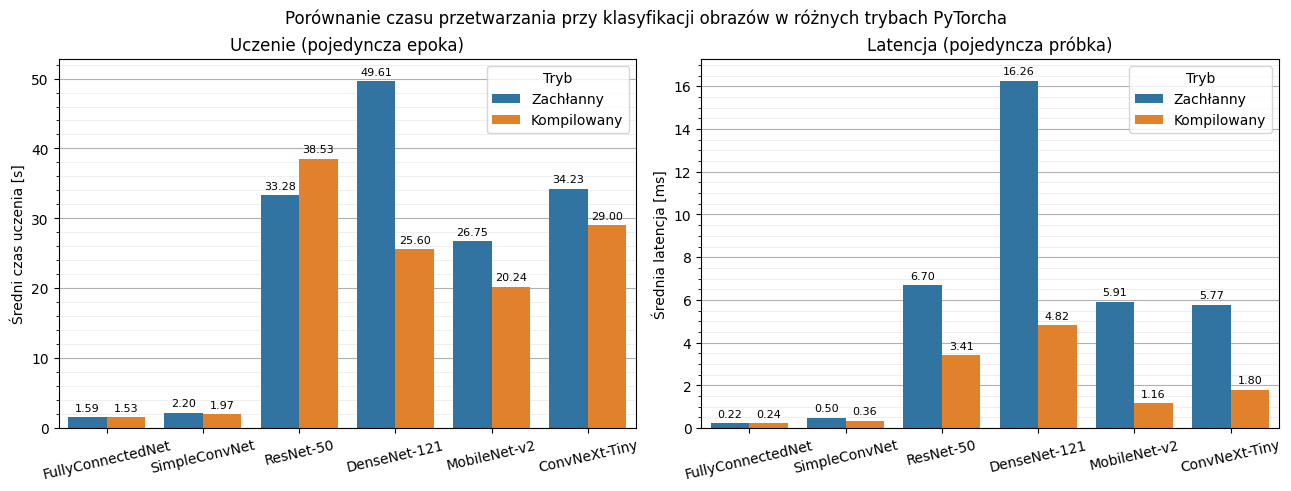

In [17]:
def clf_compile_comp_plot(data: pd.DataFrame, order: list[str], ax, ylabel: str, title: str):
	sns.barplot(data=data, x="model_name", y="elapsed_time_" + ("median" if "atencja" in title else "mean"), 
			    hue="framework", order=order, zorder=2, ax=ax)
	ax.legend(title="Tryb")
	ax.set_xlabel("")
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(ax.get_xticks())
	ax.set_xticklabels(ax.get_xticklabels(), rotation=13)
	ax.grid(axis="y", which="major", zorder=1)
	ax.minorticks_on()
	ax.tick_params(axis='x', which='minor', bottom=False)
	ax.grid(visible=True, axis="y", which="minor", alpha=0.2, zorder=1)
	_, top = ax.get_ylim()
	ax.set_ylim(top=top + (0.2 if "atencja" in title else 0.7))
	for container in ax.containers:
		ax.bar_label(container, fmt="{:.2f}", fontsize=8, padding=3)


fig, axes = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(12.8, 4.8)
fig.suptitle("Porównanie czasu przetwarzania przy klasyfikacji obrazów w różnych trybach PyTorcha")

clf_compile_comp_plot(compile_t, order=MODEL_ORDER[:-2], ax=axes[0], ylabel="Średni czas uczenia [s]", title="Uczenie (pojedyncza epoka)")
clf_compile_comp_plot(compile_l, order=MODEL_ORDER[:-2], ax=axes[1], ylabel="Średnia latencja [ms]", title="Latencja (pojedyncza próbka)")

fig.savefig("../paper/plots/5.2-1.png")


## Generacja obrazów: DCGAN

In [18]:
def dcgan_filter(mdf):
	return (
		mdf[
			(mdf.model_name == "DCGAN") & 
			~mdf.framework.isin(["PyTorch_eager", "PyTorch_compile"])
		]
		.reset_index(drop=True)
		.drop(["model_name"] + [col for col in mdf.columns if "phase" in col], axis="columns")
		.set_index(["framework"])
	)

dcgan_t = dcgan_filter(mtdf)
dcgan_e = dcgan_filter(medf)
dcgan_l = dcgan_filter(mldf)

dcgan = join_tels(dcgan_t, dcgan_e, dcgan_l)
display(dcgan)

xf = dcgan.loc["LibTorch", :]  # uzupelnic wedle uznania co mi tam bedzie potrzebne do wnioskow
yf = dcgan.loc["Matlab", :]

xf_advantage = (yf / xf * 100).drop([c for c in cpp_lt.columns if "std" in c])

display(xf_advantage)  # cuDNN wykonuje sie `x/100 razy` lub `o (x-100)%` dluzej od LT

,t_mean,t_median,t_std,e_mean,e_median,e_std,l_mean,l_median,l_std
framework,,,,,,,,,
LibTorch,34.6406,34.6450,0.0440,449.5767,449.5940,2.7514,0.8268,0.8259,0.0124
PyTorch,37.5796,37.5906,0.0413,652.7010,605.9197,137.2661,1.2570,1.2564,0.0191
TensorFlow,34.8981,34.8066,0.3828,2046.1119,2045.0248,7.4158,14.0317,13.9731,0.4699
Matlab,41.8649,41.8021,0.1381,2245.6862,2165.9865,483.8661,2.4929,2.4365,0.2026


t_mean     120.8550
t_median   120.6582
e_mean     499.5113
e_median   481.7650
l_mean     301.5165
l_median   295.0115
dtype: float64

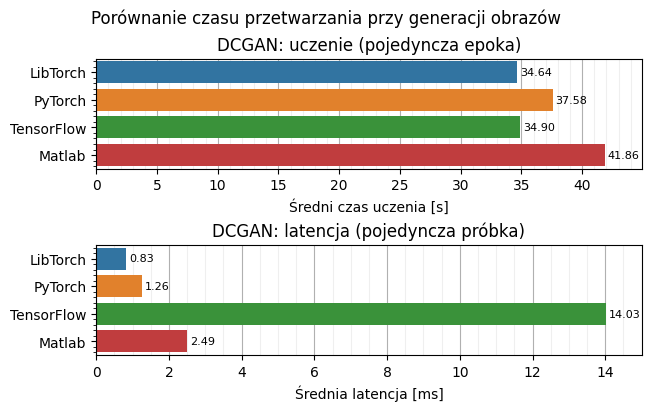

In [19]:
fig, axes = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle("Porównanie czasu przetwarzania przy generacji obrazów")
fig.set_size_inches(6.4, 4)

def dcgan_plots(data, title, xlabel, ax, xlim):
	data["hue"] = ["lt", "pt", "tf", "ml"][:data.shape[0]]
	sns.barplot(data=data, y="framework", x="elapsed_time_mean", zorder=2, ax=ax, orient="h", hue="hue")
	ax.set_ylabel("")
	ax.set_xlabel(xlabel)
	ax.set_title(title)
	ax.get_legend().remove()

	ax.grid(axis="x", which="major", zorder=1)
	ax.minorticks_on()
	ax.tick_params(axis='x', which='minor', bottom=False)
	ax.grid(visible=True, axis="x", which="minor", alpha=0.2, zorder=1)

	ax.set_xlim(right=xlim)

	for container in ax.containers:
		ax.bar_label(container, fmt="{:.2f}", fontsize=8, padding=2)

dcgan_plots(dcgan_t.reset_index(), title="DCGAN: uczenie (pojedyncza epoka)", 
			xlabel="Średni czas uczenia [s]", ax=axes[0], xlim=44.9)
dcgan_plots(dcgan_l.reset_index(), title="DCGAN: latencja (pojedyncza próbka)", 
			xlabel="Średnia latencja [ms]", ax=axes[1], xlim=15)

fig.savefig("../paper/plots/5.3-1.png")

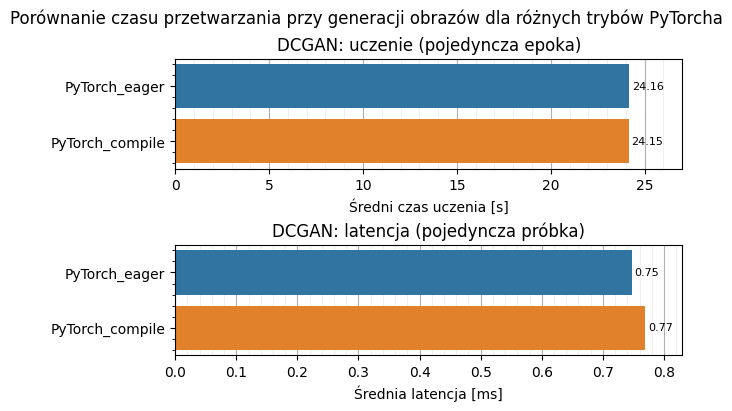

In [20]:
compiled_dcgan_t = mtdf[mtdf.framework.isin(["PyTorch_eager", "PyTorch_compile"]) & 
						(mtdf.model_name == "DCGAN")].reset_index()
compiled_dcgan_l = mldf[mldf.framework.isin(["PyTorch_eager", "PyTorch_compile"]) & 
						(mldf.model_name == "DCGAN") &
						(mldf.phase == "latency")].reset_index()

fig, axes = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle("Porównanie czasu przetwarzania przy generacji obrazów dla różnych trybów PyTorcha")
fig.set_size_inches(6.4, 4)

dcgan_plots(compiled_dcgan_t, title="DCGAN: uczenie (pojedyncza epoka)", 
			xlabel="Średni czas uczenia [s]", ax=axes[0], xlim=27)
dcgan_plots(compiled_dcgan_l, title="DCGAN: latencja (pojedyncza próbka)", 
			xlabel="Średnia latencja [ms]", ax=axes[1], xlim=0.83)

do porównania DCGANa w torch.compile chyba lepiej uzyc tabelki niz wykresu bo to wyglada slabo jak barszcz XD

In [21]:
display(compiled_dcgan_t)
display(compiled_dcgan_l)

,index,framework,model_name,elapsed_time_mean,elapsed_time_median,elapsed_time_std,hue
0,37,PyTorch_eager,DCGAN,24.1647,24.2337,0.6205,lt
1,44,PyTorch_compile,DCGAN,24.1547,24.1442,0.6908,pt


,index,framework,model_name,phase,elapsed_time_mean,elapsed_time_median,elapsed_time_std,hue
0,43,PyTorch_eager,DCGAN,latency,0.7472,0.6513,0.2188,lt
1,57,PyTorch_compile,DCGAN,latency,0.7691,0.7578,0.1000,pt


## Detekcja obiektów z YOLOv8m
wszystko w pliku `yolo-comp.ipynb`